In [1]:
# --- Synthetic Ice stream with Data assimilation --- 

In [2]:
# --- Synthetic ice stream example ---
import firedrake

import numpy as np
import tqdm
import matplotlib.pyplot as plt
from scipy.stats import norm, multivariate_normal

import warnings
warnings.filterwarnings("ignore")

firedrake:WARNING OMP_NUM_THREADS is not set or is set to a value greater than 1, we suggest setting OMP_NUM_THREADS=1 to improve performance


In [3]:
# --- Geometry and input data ---
# an elongated fjord-like geometry (12km wide and 50km from the inflow boundary to the ice front)
# Lx, Ly = 50e3, 12e3
# nx, ny = 48, 32
Lx, Ly = 50e2, 12e2
nx, ny = 12, 8
mesh = firedrake.RectangleMesh(nx, ny, Lx, Ly)

Q = firedrake.FunctionSpace(mesh, "CG", 2)
V = firedrake.VectorFunctionSpace(mesh, "CG", 2)

x, y = firedrake.SpatialCoordinate(mesh)

# the bedrock slopes down from 200m ABS at the inflow boundary to -400m at the terminus
b_in, b_out = 200, -400
b = firedrake.interpolate(b_in - (b_in - b_out) * x / Lx, Q)

s_in, s_out = 850, 50
s0 = firedrake.interpolate(s_in - (s_in - s_out) * x / Lx, Q)

h0 = firedrake.interpolate(s0 - b, Q)

# --- Evaluate the driving stress ---
from icepack.constants import (
    ice_density as rho_I,
    water_density as rho_W,
    gravity as g,
)

h_in = s_in - b_in
ds_dx = (s_out - s_in) / Lx
tau_D = -rho_I * g * h_in * ds_dx
print(f"{1000*tau_D} kPa")

# --- Guess for the initial velocity ---
u_in, u_out = 20, 2400
velocity_x = u_in + (u_out - u_in) * (x / Lx) ** 2
u0 = firedrake.interpolate(firedrake.as_vector((velocity_x, 0)), V)

# --- Choosing the friciton coefficient ---
import icepack

T = firedrake.Constant(255.0)
A = icepack.rate_factor(T)

from icepack.constants import weertman_sliding_law as m

expr = (0.95 - 0.05 * x / Lx) * tau_D / u_in**(1 / m)
C = firedrake.interpolate(expr, Q)

p_W = rho_W * g * firedrake.max_value(0, h0 - s0)
p_I = rho_I * g * h0
phi = 1 - p_W / p_I

# --- Define the friction law ---
import icepack.models.friction

# wrapper fuction around the default parametisation
def weertman_friction_with_ramp(**kwargs):
    u = kwargs["velocity"]
    h = kwargs["thickness"]
    s = kwargs["surface"]
    C = kwargs["friction"]

    p_W = rho_W * g * firedrake.max_value(0, h - s)
    p_I = rho_I * g * h
    phi = 1 - p_W / p_I
    return icepack.models.friction.bed_friction(
        velocity = u,
        friction = C*phi,
    )

# --- Define the model ---
model_weertman = icepack.models.IceStream(friction = weertman_friction_with_ramp)
opts = {"dirichlet_ids": [1], "side_wall_ids": [3,4]}
solver_weertman = icepack.solvers.FlowSolver(model_weertman, **opts)

u0 = solver_weertman.diagnostic_solve(
                            velocity = u0,
                            thickness = h0,
                            surface = s0,
                            fluidity = A,
                            friction = C
)

from firedrake import sqrt, inner

expr = -1e3*C*phi*sqrt(inner(u0, u0))**(1/m-1)*u0
tau_b = firedrake.interpolate(expr, V)

935.5600800000001 kPa


In [4]:
num_years = 50
timesteps_per_year = 2

dt = 1.0 / timesteps_per_year
num_timesteps = num_years * timesteps_per_year

a_in = firedrake.Constant(1.7)
da = firedrake.Constant(-2.7)
a  = firedrake.interpolate(a_in + da * x / Lx, Q)

h = h0.copy(deepcopy=True)
u = u0.copy(deepcopy=True)

# Ensemble parameters
# dt = 10
tm = num_years
# nt = int(tm/dt)
nt = num_timesteps
t = np.linspace(0,tm,nt+1)

# Dimension of model state
state_variables = 3
hdim = h0.dat.data_ro.size
nd = state_variables*hdim

#  initial conditions
np.random.seed(seed=1)
sig_model   = 1e-1
sig_obs     = 1e-2
sig_Q       = 1e-2

Cov_model = (sig_model**2)*np.eye(nd)

Q_err = (sig_Q**2)*np.eye(nd)

# dt_m = 15 # time interval between observations
# tm_m = 250 # maximum time of observations
# nt_m = int(tm_m/dt_m) # number of observations instants
# ind_m = (np.linspace(int(dt_m/dt),int(tm_m/dt),nt_m)).astype(int) # indexes of observation instants
# t_m = t[ind_m] # time instants of observations

sig_b= 0.1

N = 30 # ensemble size

# no of observations
n_obs = 10 
params = {"m_obs": n_obs}
dt_m = 15 # time interval between observations
nt_m = n_obs
ind_m = (np.linspace(int(dt_m/dt),int(tm/dt),nt_m)).astype(int) # indexes of observation instants
t_m = t[ind_m] # time instants of observations

In [5]:
# Observation operator
def Obs(huxg_virtual_obs, m_obs):
    # Determine the size of the observation vector
    n = huxg_virtual_obs.shape[0]
    m = m_obs

    # Initialize the H matrix with zeros
    H = np.zeros((m * 2 + 1, n))

    # Calculate the distance between measurements
    di = int((n - 2) / (2 * m))  # Python uses int for integer division

    # Fill in the H matrix
    for i in range(m):
        H[i, i * di] = 1
        H[m + i, int((n - 2) / 2) + i * di] = 1


    # Final element of H matrix
    H[m * 2, n - 2] = 1  # Adjust for 0-based indexing

    # Perform matrix multiplication
    z = H @ huxg_virtual_obs  # '@' operator for matrix multiplication in Python
    return z

# Jacobian of the observation operator ----------------------
def JObs(n_model, m_obs):
    # Initialize the H matrix with zeros
    n = n_model
    m = m_obs
    H = np.zeros((m * 2 + 1, n))

    # Calculate the distance between measurements
    di = int((n - 2) / (2 * m))  # Convert distance to an integer

    # Fill in the H matrix
    for i in range(m):  # Python uses 0-based indexing
        H[i, i * di] = 1  # Adjust for 0-based indexing
        H[m + i, int((n - 2) / 2) + i * di] = 1  # Adjust for 0-based indexing

    # Final element of H matrix
    H[m * 2, n - 2] = 1  # Adjust for 0-based indexing

    return H

In [6]:
# Ensemble Kalman Filters
# EnKF analysis step function ------------------------------
def EnKF_analysis_step(huxg_ens, huxg_obs, ObsFun, JObsFun, Cov_obs, Cov_model, params, taper=None):
    """
    Analysis step of the Ensemble Kalman Filter (EnKF).
    
    huxg_ens: ndarray (n x N) - The ensemble matrix of model states (n is state size, N is ensemble size).
    huxg_obs: ndarray (m,) - The observation vector (m is measurement size).
    ObsFun: Function - Observation function.
    JObsFun: Function - Jacobian of the observation function.
    Cov_obs: ndarray (m x m) - Observation covariance matrix.
    Cov_model: ndarray (n x n) - Model covariance matrix.
    params: dict - Dictionary containing parameters like "m_obs".
    taper: ndarray (n x n) - Covariance taper matrix.
    
    Returns:
    analysis_ens: ndarray (n x N) - The updated ensemble after analysis.
    analysis_cov: ndarray (n x n) - The updated covariance after analysis.
    """
    n, N = huxg_ens.shape  # n is the state size, N is the ensemble size
    m = huxg_obs.shape[0]  # Measurement size (m)

    # Compute the ensemble mean
    huxg_ens_mean = np.mean(huxg_ens, axis=1, keepdims=True)  # mean of model forecast ensemble
    
    # Compute the Jacobian of the observation operator
    Jobs = JObsFun(n, params["m_obs"])  # Jacobian of the observation operator
    
    # Compute the Kalman Gain
    KalGain = Cov_model @ Jobs.T @ np.linalg.inv(Jobs @ Cov_model @ Jobs.T + Cov_obs)

    # Initialize variables
    obs_virtual = np.zeros((m, N))  # Virtual observations for the ensemble
    analysis_ens = np.zeros_like(huxg_ens)  # Analysis ensemble

    # Perform the analysis for each ensemble member
    for i in range(N):
        # Generate virtual observations using multivariate normal distribution
        obs_virtual[:, i] = huxg_obs + multivariate_normal.rvs(mean=np.zeros(m), cov=Cov_obs)
       
        # Update the ensemble member with the Kalman gain
        analysis_ens[:, i] = huxg_ens[:, i] + KalGain @ (obs_virtual[:, i] - ObsFun(huxg_ens[:, i], params["m_obs"]))
    
    # Compute the mean of the analysis ensemble
    analysis_ens_mean = np.mean(analysis_ens, axis=1, keepdims=True)
    
    # Compute the analysis error covariance
    analysis_cov = (1 / (N - 1)) * (analysis_ens - analysis_ens_mean) @ (analysis_ens - analysis_ens_mean).T
    # analysis_cov = analysis_cov * taper  # Apply covariance tapering
    
    return analysis_ens, analysis_cov

In [7]:
from firedrake import Function
def run_simualtion(solver, h, u, a, **kwargs):
    # for i in tqdm.trange(num_timesteps):
    h = solver.prognostic_solve(
        dt = dt,
        thickness = h,
        velocity = u,
        accumulation = a,
        thickness_inflow = h0,
    )

    s = icepack.compute_surface(thickness = h, bed = b)

    u = solver.diagnostic_solve(
        velocity = u,
        thickness = h,
        surface = s,
        **kwargs
    )

    return h, u

In [8]:
# --- Forecast step ---
def forecast_step(ensemble, Nens, ndim,nos):
    """ensemble: packs the state variables:h,u,v of the ensemble members
                 where h is thickness, u and v are the x and y components 
                 of the velocity field
        dt: time step
        Nens: number of ensemble members
        ndim: number of dimensions of the state variables
        a: accumulation rate
        args: other arguments: b, ela, max_a, da_ds

    Returns: ensemble: updated ensemble members
             a: updated accumulation rate
    """
    
    # iterate over the ensemble members
    for ens in range(Nens):
        h_vec = ensemble[:ndim, ens]
        u_vec = ensemble[ndim:2*ndim, ens]
        v_vec = ensemble[2*ndim:, ens]

        # create firedrake functions from the ensemble members
        h = Function(Q)
        h.dat.data[:] = h_vec[:]

        u = Function(V)
        u.dat.data[:,0] = u_vec[:]
        u.dat.data[:,1] = v_vec[:]

        # call the ice stream model to update the state variables
        h, u = run_simualtion(solver_weertman, h, u, a, fluidity = A, friction = C)

        # update the ensemble members with the new state variables and noise 
        ensemble[:ndim, ens]        = h.dat.data_ro      + nos[:ndim]
        ensemble[ndim:2*ndim, ens]  = u.dat.data_ro[:,0] + nos[ndim:2*ndim]
        ensemble[2*ndim:, ens]      = u.dat.data_ro[:,1] + nos[2*ndim:]
    return ensemble


In [9]:
# True simulation
statevec_true = np.zeros([nd,nt+1])
# hTrue[:,0] = h0.dat.data_ro
statevec_true[:hdim,0] = h0.dat.data_ro
statevec_true[hdim:2*hdim,0] = u0.dat.data_ro[:,0]
statevec_true[2*hdim:,0] = u0.dat.data_ro[:,1]

hu_obs = np.zeros([nd,nt_m])
km = 0
h = h0.copy(deepcopy=True)
u = u0.copy(deepcopy=True)
# s = icepack.compute_surface(thickness=h, bed=b)
for step in tqdm.trange(nt):
    
    # call the ice stream model to update the state variables
    h , u = run_simualtion(solver_weertman, h, u, a, fluidity = A, friction = C)

    # hTrue[:,step+1] = h.dat.data_ro
    statevec_true[:hdim,step+1] = h.dat.data_ro
    statevec_true[hdim:2*hdim,step+1] = u.dat.data_ro[:,0]
    statevec_true[2*hdim:,step+1] = u.dat.data_ro[:,1]

    if (km<nt_m) and (step+1 == ind_m[km]):
        # hu_vir = Obs(statevec_true[:,step+1],params["m_obs"])
        hu_vir = statevec_true[:,step+1]
        hu_vir += np.random.normal(0,sig_obs,hu_vir.shape)
        hu_obs[:,km] = hu_vir
        # hu_obs[:,km] = statevec_true[:,step+1] + np.random.normal(0,sig_obs,[nd,])
        km = km + 1

100%|██████████| 100/100 [00:18<00:00,  5.53it/s]


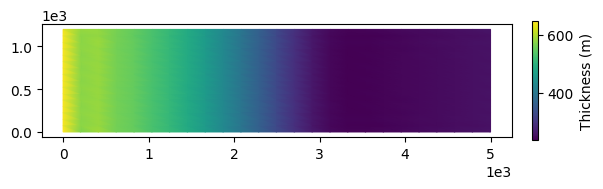

In [10]:
import icepack.plot
fig, axes = icepack.plot.subplots()
step = 50
hh = firedrake.Function(Q)
hh.dat.data[:] = statevec_true[:hdim,step]
colors = firedrake.tripcolor(hh, axes=axes)
fig.colorbar(colors, ax=axes, fraction=0.012, pad=0.04, label="Thickness (m)")


In [11]:
obs_vir = statevec_true + (np.random.normal(0,sig_obs,nd)).reshape(nd,1)
hu_obs_ = Obs(obs_vir, params["m_obs"])

# ts = np.arange(0,nt+1,dt)
ts = t
# ts_obs = np.arange(10,tm+1,25)
ts_obs = np.linspace(10,tm+1,hu_obs_.shape[1])
ts_obs.shape

(101,)

In [12]:
# Intialize ensemble
statevec_bg = np.zeros((nd,nt+1))
statevec_ens_mean = np.zeros((nd,nt+1))
statevec_ens = np.zeros((nd,N))
statevec_ens_full = np.zeros((nd,N,nt+1))

# statevec_bg[:,0] = h0.dat.data_ro
statevec_bg[:hdim,0] = h0.dat.data_ro
statevec_bg[hdim:2*hdim,0] = u0.dat.data_ro[:,0]
statevec_bg[2*hdim:,0] = u0.dat.data_ro[:,1]

# statevec_ens_mean[:,0] = h0.dat.data_ro
statevec_ens_mean[:hdim,0] = h0.dat.data_ro
statevec_ens_mean[hdim:2*hdim,0] = u0.dat.data_ro[:,0]
statevec_ens_mean[2*hdim:,0] = u0.dat.data_ro[:,1]

# Intialize ensemble thickness and velocity
h_ens = np.array([h0.dat.data_ro for _ in range(N)])
u_ens = np.array([u0.dat.data_ro[:,0] for _ in range(N)])
v_ens = np.array([u0.dat.data_ro[:,1] for _ in range(N)])

for i in range(N):
    # perturbed_state = multivariate_normal.rvs(mean=np.zeros(nd-1), cov=Cov_model[:-1,:-1])
    perturbed_state = multivariate_normal.rvs(mean=np.zeros(nd), cov=Cov_model)

    # statevec_ens[:-1,i] = h0.dat.data_ro[:-1] + perturbed_state
    # statevec_ens[:hdim-1,i]         = h0.dat.data_ro[:-1] + perturbed_state[:hdim-1]
    # statevec_ens[hdim:2*hdim-1,i]   = u0.dat.data_ro[:-1,0] + perturbed_state[hdim:2*hdim-1]
    # statevec_ens[2*hdim:nd-1,i]     = u0.dat.data_ro[:-1,1] + perturbed_state[2*hdim:nd-1]
    statevec_ens[:hdim,i]       = h0.dat.data_ro + perturbed_state[:hdim]
    statevec_ens[hdim:2*hdim,i] = u0.dat.data_ro[:,0] + perturbed_state[hdim:2*hdim]
    statevec_ens[2*hdim:,i]     = u0.dat.data_ro[:,1] + perturbed_state[2*hdim:]

    # # statevec_ens[-1,i] = h0.dat.data_ro[-1]
    # statevec_ens[hdim-1,i]   = h0.dat.data_ro[-1]
    # statevec_ens[2*hdim-1,i] = u0.dat.data_ro[-1,0]
    # statevec_ens[-1,i]       = u0.dat.data_ro[-1,1]

statevec_ens_full[:,:,0] = statevec_ens
# statevec_ens_full


In [13]:
# --- Run the model with the Ensemble Kalman Filter ---
km = 0
h = h0.copy(deepcopy=True)
u = u0.copy(deepcopy=True)
# sb = icepack.compute_surface(thickness=h, bed=b)
# sf = icepack.compute_surface(thickness=h, bed=b)
nos = np.random.multivariate_normal(np.zeros(nd), Q_err)

hb = Function(Q)
ub = Function(V)
for k in tqdm.trange(nt):
    # background step
    hb.dat.data[:]   = statevec_bg[:hdim,k]
    ub.dat.data[:,0] = statevec_bg[hdim:2*hdim,k]
    ub.dat.data[:,1] = statevec_bg[2*hdim:,k]
    hb, ub = run_simualtion(solver_weertman, hb, ub, a, fluidity = A, friction = C)
    statevec_bg[:hdim,k+1] = hb.dat.data_ro
    statevec_bg[hdim:2*hdim,k+1] = ub.dat.data_ro[:,0]
    statevec_bg[2*hdim:,k+1] = ub.dat.data_ro[:,1]

    # forecast step
    statevec_ens = forecast_step(statevec_ens, N, hdim,nos)

    # Compute the ensemble mean
    statevec_ens_mean[:,k+1] = np.mean(statevec_ens, axis=1)

    # Compute the model covariance
    diff = statevec_ens - np.tile(statevec_ens_mean[:,k+1].reshape(-1,1),N)
    Cov_model = 1/(N-1) * diff @ diff.T

    # Analysis step
    # if ts[k+1] in ts_obs:
    if (km < nt_m) and (k+1 == ind_m[km]):
        idx_obs = np.where(ts[k+1] == ts_obs)[0]

        Cov_obs = sig_obs**2 * np.eye(2*params["m_obs"]+1)

        # make the observation
        # obs_vir = statevec_true[:,idx_obs[0]] + np.random.normal(0,sig_obs,nd)
        # obs_vir = statevec_true[:,km] + np.random.normal(0,sig_obs,nd)

        hu_ob = Obs(hu_obs[:,km], params["m_obs"])

        # Compute the analysis ensemble
        statevec_ens, Cov_model = EnKF_analysis_step(statevec_ens, hu_ob, Obs, JObs, Cov_obs, Cov_model, params)

        statevec_ens_mean[:,k+1] = np.mean(statevec_ens, axis=1)

        km += 1

    # Save the ensemble
    statevec_ens_full[:,:,k+1] = statevec_ens

100%|██████████| 100/100 [12:25<00:00,  7.46s/it]


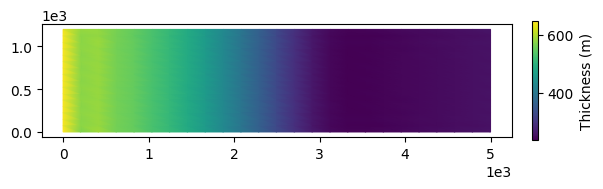

In [14]:
fig, axes = icepack.plot.subplots()
step = 50
hh = firedrake.Function(Q)
hh.dat.data[:] = statevec_true[:hdim,step]
colors = firedrake.tripcolor(hh, axes=axes)
fig.colorbar(colors, ax=axes, fraction=0.012, pad=0.04, label="Thickness (m)")

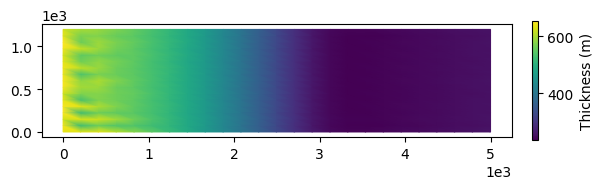

In [15]:
fig, axes = icepack.plot.subplots()
step = 50
hh = firedrake.Function(Q)
hh.dat.data[:] = statevec_ens_mean[:hdim,step]
colors = firedrake.tripcolor(hh, axes=axes)
fig.colorbar(colors, ax=axes, fraction=0.012, pad=0.04, label="Thickness (m)")